# Example training notebook
#### This is an example notebook to step through the data generation and model training process. The training will be much faster with a GPU. Required packages (python3) are:
1. Numpy, pandas, random, scikit-learn, matplotlib
2. Tensorflow, Keras

### Module imports

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import os 
import functools
import time, timeit

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Populating the interactive namespace from numpy and matplotlib


### Import and config of tensorflow and GPU options.
We recommend following the instructions on the Convotate git page for
configuring the right Anaconda environment for your OS.
Please note that tensorflow requires a GPU with cuda compute
capability greater than 3.0, else you will need to use a CPU system.

In [2]:
## Default GPU configuration so Keras uses the GPU. 
## Comment the next line out if you do not have a GPU.
os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
import tensorflow as tf
from tensorflow.keras.backend import set_session

## If you are getting memory errors with the GPU, uncommenting next line might help
# config.gpu_options.per_process_gpu_memory_fraction = 0.5

sess = tf.InteractiveSession()#(config=config)
set_session(sess)

from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape, Permute
from keras.layers import Conv1D,MaxPool1D #Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten
from keras.layers import LeakyReLU, Dropout, PReLU
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.engine.topology import Layer
import keras.backend as K

Using TensorFlow backend.


## Classes and functions

In [3]:
def time_it(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        t = time.time()
        f = func(*args, **kwargs)
        print('%s , dt = %.2g s' %(func.__name__,time.time()-t))
        return f
    return wrapper

In [4]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

class EpochHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.best_weights = None
        self.best_val_acc = 0

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        print('Ep: %d\tAcc: %.4f\tVal. Acc: %.4f' % (epoch, self.acc[-1], self.val_acc[-1]))
        if self.val_acc[-1] > self.best_val_acc:
            self.best_val_acc = self.val_acc[-1]
            print('Val Acc improved; getting weights')
            self.best_weights = self.model.get_weights()
            print('saving model')
            self.model.save('superclass_test_deep_model_fig_20190516_SPP32.h5')  # %(self.model.__model_name__))

### Spatial Pyramidal Pooling
We have modified this code for our 1D data.

In [5]:
class SpatialPyramidPooling1D(Layer):
    """Spatial pyramid pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        3D tensor with shape:
        `(samples, rows, channels)` if dim_ordering='tf'.
    # Output shape
        2D tensor with shape:
        `(samples, channels * sum([i * i for i in pool_list])`
    """

    def __init__(self, pool_list, **kwargs):

        self.dim_ordering = K.image_dim_ordering()
        assert self.dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'
        self.pool_list = pool_list
        self.num_outputs_per_channel = sum([i for i in pool_list])

        super(SpatialPyramidPooling1D, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'th':
            self.nb_channels = input_shape[1]
        elif self.dim_ordering == 'tf':
            self.nb_channels = input_shape[-1]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
        config = {'pool_list': self.pool_list}
        base_config = super(SpatialPyramidPooling1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):
        input_shape = K.shape(x)
        if self.dim_ordering == 'th':
            num_rows = input_shape[2]
        elif self.dim_ordering == 'tf':
            num_rows = input_shape[1]
        row_length = [K.cast(num_rows, 'float32') / i for i in self.pool_list]

        outputs = []
        if self.dim_ordering == 'tf':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')
                        new_shape = [input_shape[0], y2 - y1,
                                     input_shape[-1]]
                        x_crop = x[:, y1:y2, :]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(1,))
                        outputs.append(pooled_val)
        
        else:
            raise TypeError()

        if self.dim_ordering == 'th':
            outputs = K.concatenate(outputs)
        elif self.dim_ordering == 'tf':
            outputs = K.concatenate(outputs)
 
        return outputs

In [6]:
class DMN_Conv:
    def __init__(self,input_tensor, kernel_size = (3,3), strides=(1,1), var_explained = 0.99, **kw):
        self.kernel_size = list(kernel_size)
        self.strides = list(strides)
        self.input_tensor = input_tensor
        self.get_patches()
        self.get_rho()
        self.get_eigs()
        self.get_num_filters(var_explained)
        self.make_weights()
    
    @time_it
    def get_patches(self):
        self.patches = tf.image.extract_image_patches( self.input_tensor, 
                ksizes = [1]+list(self.kernel_size)+[1],
                strides = [1]+list(self.strides)+[1],
                rates = [1,1,1,1], padding = 'VALID')    
    
    @time_it    
    def get_rho(self):
        """To be able to update the eigenvectors later, we will keep the covariance matrix, instead of doing SVD directly. 
        In most cases since # of samples N >> dim this won't be much more costly than SVD"""
        ims = tf.reshape(self.patches, [-1, self.patches.shape.as_list()[-1]])
        self.rho = tf.matmul(ims, ims, transpose_a=True)
    
    @time_it
    def get_eigs(self):
        """svd automatically finds SVs from largest to smallest, so no sorting is needed for PCA."""
        self.eigs = tf.svd(self.rho)
    
    @time_it    
    def get_num_filters(self, v):
#         ei = self.eigs[0].eval()
#         ex = (ei / ei.sum()).cumsum()
#         self.num_filters = (ex < v).sum()
        c = tf.cumsum(self.eigs[0] )
        c = c/ c[-1]
        self.num_filters = tf.reduce_sum(tf.cast(c < v, dtype=tf.int32))

    @time_it
    def make_weights(self):
        self.weights = tf.reshape(self.eigs[1], list(self.kernel_size) + [self.input_tensor.shape.as_list()[-1],-1,] )[..., :self.num_filters]


def plot_ws(ws, idx='all'):
    figure(figsize=(12,12))
    n = ws.shape[-1]
    r = np.ceil(np.sqrt(n))
    for i in range(n):
        subplot(r,r,i+1)
        w = (ws[...,i] if idx == 'all' else ws[...,idx,i]) # ws.shape[-2]==3
        imshow(w +.5, interpolation='bicubic')

In [7]:
class DMN_Class_Data:
    def __init__(self, x,y):
        self.x, self.y = self.prep_input(x), np.asarray(y)
        self.get_class_indices()
        self.get_all_class_tensors()
    
    @time_it
    def prep_input(self, x):
        x = np.asarray((x if len(x.shape)==4 else x[...,newaxis]))
        return (x-x[:2].min()) / x[:2].max() - 0.5
    
    @time_it
    def get_all_class_tensors(self):
        self.class_tensors = {c: tf.constant(self.x[self.classes[c]], tf.float32) for c in self.classes} 
        
    @time_it
    def get_class_indices(self):
        self.classes = set(self.y.flatten())
        self.classes = {}
        for i, c in enumerate(self.y.flatten()):
            self.classes.setdefault(c,[])
            self.classes[c] += [i]

In [8]:
class DMN_Layer:
    def __init__(self, x,y, frac = 0.5, **kwargs):
        self._n = int(frac*len(x))
        self.Training_Data = DMN_Class_Data(x[:self._n],y[:self._n])
        self.get_class_weights(**kwargs)
        
    @time_it
    def get_class_weights(self, **kw):
        self.class_weights = {}
        for c, ten in self.Training_Data.class_tensors.items():
            self.class_weights[c] = DMN_Conv(ten, **kw)
        
        

In [9]:
def make_model_name(model):
    mn = []
    for l in model.layers:
        nam = l.name
        if 'conv' in nam:
            s = 'Conv1D(%d,%d)'%((l.filters,)+l.kernel_size)  
        elif 'max_pool' in nam:
            s = 'MaxPool%d'%l.pool_size
        elif 'dense' in nam:
            s = 'Dense%d'%l.units
        elif 'dropout' in nam:
            s = 'Dropout%.1g'%l.rate
        else:
            continue
        mn += [s]
    return '-'.join(mn)

class EpochHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.best_weights = None
        self.best_val_acc = 0

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        print('Ep: %d\tAcc: %.4f\tVal. Acc: %.4f' %(epoch, self.acc[-1], self.val_acc[-1]) )
        if self.val_acc[-1] > self.best_val_acc:
            self.best_val_acc = self.val_acc[-1]
            print('Val Acc improved; getting weights')
            self.best_weights = self.model.get_weights()
        


In [27]:
class Train_Proteins:
    def __init__(self,sequence_file = './data/training_validation/training_sequences.txt' ,
                labels_file = './data/training_validation/labels.txt',
                ontology_file = './data/training_validation/ontology_merged.txt'):
        self.get_ontology(ontology_file)
        print('Loading protein sequences...')
        self.proteins = pd.read_csv(sequence_file, sep = '\t')
        print('Loading protein class data...')
        self.patric = pd.read_csv(labels_file, sep = '\t')
        # Unfortunately, to compare patric and prot seq data we need to load both files into RAM... 
        
        self.prep_seqs()
        self.get_amino_acids()
        self.set_seq_lengths()
        self.compile_class_data(chosen_level)
        
    def get_ontology(self, ont_file):
        """mapping 'Subsystem' to other levels ('Superclass', 'Class', 'Subclass') """
        ont = pd.read_csv(ont_file, sep = '\t')
        self.ontology = {ont['Subsystem Merged'][i]: {k: str(ont[k][i]).strip() for k in ['Superclass', 'Class', 'Subclass']} 
                         for i in range(len(ont))}
        
        
    @time_it    
    def prep_seqs(self):
        # index all gene patric ids
        # ignore duplicates, we checked, the sequences are unique 
        print('preparing sequences...')
        self.pid2index = {k:i for i, k in enumerate(self.patric['PATRIC ID'].values)}        
        self.pseq_shared = {k:seq for k, seq in self.proteins.values if k in self.pid2index}

    @time_it    
    def get_amino_acids(self):
        print('getting amino acid list...')
        import string
        self.amino_acids = {a:i for i,a in enumerate(string.ascii_uppercase+'_')} # '_':unknown stuff
        print(self.amino_acids)

    @time_it    
    def set_seq_lengths(self, sigma = 3, viz=True):
        print('calculating length truncation for sequences', end=', ' )
        seq_lens = np.array([len(self.pseq_shared[k]) for k in self.pseq_shared])
        self.min_seq_length = int(np.exp(np.log(seq_lens).mean()-sigma*np.log(seq_lens).std()))
        self.max_seq_length = int(np.exp(np.log(seq_lens).mean()+sigma*np.log(seq_lens).std()))
        print('Length = %d' %self.max_seq_length)
        if viz:
            h= plt.hist(np.log10(seq_lens), 100, log = 1)
            plt.xlabel('log sequence length')
            plt.ylabel('count')
            plt.show()

    def make_barcode(self, seq):
        protein_barcodes = np.zeros((1950, len(self.amino_acids)), dtype = np.float16)
        s = np.sqrt(len(self.amino_acids))
        for i2,j in enumerate(seq[:1950]):
            protein_barcodes[i2,self.amino_acids[j]] = 1/s
        return protein_barcodes
    
    @time_it
    def compile_class_data(self, class_level = 3, min_len ='auto'):
        """class_level:
            0: Superclass, 1: Class, 2: Subclass, 3: Subsystem Name
        min_len: minimum length of sequence to include.      
        """
        min_len = (self.min_seq_length if min_len == 'auto' else min_len)
        label = lambda i: '>'.join([str(j).strip() for j in i]) 
        
        self.class_level = ['Superclass', 'Class', 'Subclass','Subsystem Merged'][:class_level+1]
        
        # instead of directly joining all levels, we will use the ontology
        labs = []
        missing = set()
        for i in self.patric[['Superclass', 'Class', 'Subclass','Subsystem Merged']].values:
            try:
                sub_sys = self.ontology[i[-1]]
                lab = label([sub_sys[k] for k in self.class_level[:3]])
                if class_level == 3:
                    lab += '>'+str(i[-1]).strip()
                
                labs += [lab]
            except KeyError:
                t = tuple(i)
                if t not in missing:
                    print(t)
                    missing.add(t)
        
        s = set(labs)
        
        print("Compiling label information; level: %s" %(self.class_level[class_level]))
        self.patric_class_names_to_index = {k:i for i,k in enumerate(sorted(s))}
        self.patric_id_to_class = {p:s for s,p in zip(labs, self.patric['PATRIC ID'].values) }
        self.class_gene_list = {k:[] for k in self.patric_class_names_to_index}
        for p in self.pseq_shared: 
            if len(self.pseq_shared[p]) < min_len: continue
            try:
                self.class_gene_list[self.patric_id_to_class[p]] += [p]
            except KeyError:
                continue
        self.class_sizes = {k:len(v) for k,v in self.class_gene_list.items()}
        # to create training batches, we should keep consistent indices
        self.rand_indices = {k: np.argsort(np.random.rand(self.class_sizes[k])) for k in self.class_sizes}
        self.batch_num = 0
 
    @time_it
    def make_training_data(self, batch_size = 120000):
        y_train = []
        self.X_train = []
        self.X_train_ids = []

        m = batch_size / len(self.class_gene_list)

        for k in self.class_gene_list:
            # choose at most m genes randomly
            numGenesToSelect=min(int(m), len(self.class_gene_list[k]))
            numGenesInCategory=len(self.class_gene_list[k])
            
            geneIndices=random.sample(range(0, numGenesInCategory), numGenesToSelect)
            
            for i in geneIndices:
                g = self.class_gene_list[k][i]
                self.X_train_ids += [g]
                y_train += [self.patric_class_names_to_index[self.patric_id_to_class[g]]]
                self.X_train += [self.make_barcode(self.pseq_shared[g]) ] 

        idx1 = np.argsort(np.random.rand(len(y_train))) 
        self.geneIndices = geneIndices
        self.IDX1 = idx1
        self.X_train = np.array(self.X_train)[idx1]
        self.X_train_ids = np.array(self.X_train_ids)[idx1]
        
        self.Y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(self.patric_class_names_to_index))[idx1]
        



# Create training data
Training and validation data are housed in separate files

Loading protein sequences...
Loading protein class data...
preparing sequences...
prep_seqs , dt = 0.019 s
getting amino acid list...
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '_': 26}
get_amino_acids , dt = 4.7e-05 s
calculating length truncation for sequences, Length = 2107


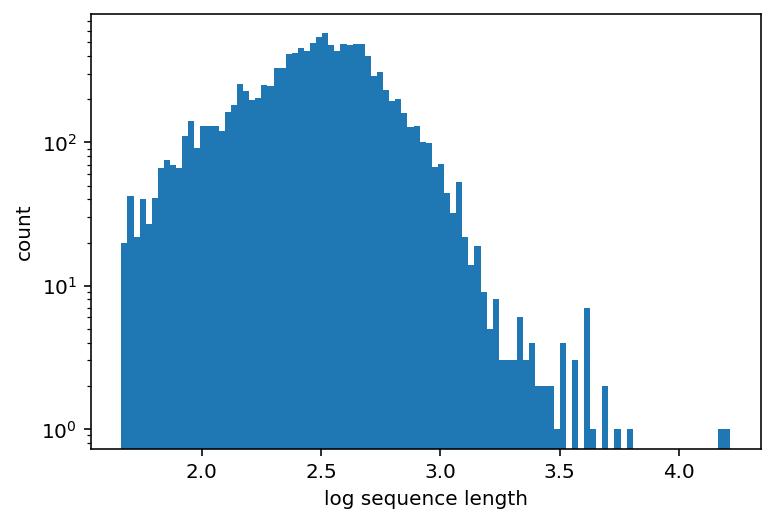

set_seq_lengths , dt = 0.57 s
Compiling label information; level: Subsystem Merged
compile_class_data , dt = 0.057 s
Loading protein sequences...
Loading protein class data...
preparing sequences...
prep_seqs , dt = 0.0056 s
getting amino acid list...
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '_': 26}
get_amino_acids , dt = 0.00036 s
calculating length truncation for sequences, Length = 1963


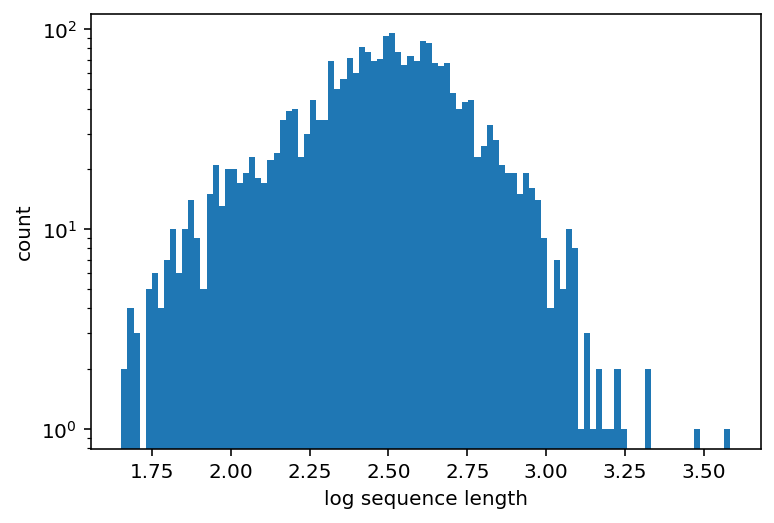

set_seq_lengths , dt = 0.57 s
Compiling label information; level: Subsystem Merged
compile_class_data , dt = 0.051 s


In [29]:
## Assign files
training_sequence_file = './data/training_validation/training_sequences.txt'
validation_sequence_file = './data/training_validation/test_sequences.txt'
labels_file = './data/training_validation/labels.txt'

# training_sequence_file = '/home/fish0208/amazons3/protclass/patricdata/training/FinalDataFiles/train_aaseq_fig_only_over30aa.txt'
# validation_sequence_file = '/home/fish0208/amazons3/protclass/patricdata/training/FinalDataFiles/validation_aaseq_fig_only_over30aa.txt'
# labels_file = '/home/fish0208/amazons3/protclass/patricdata/training/FinalDataFiles/ssid_universal_190612_lowfreq_andAA_cut.txt'

## Choose level. 0 = Superclass, 1 = Class, 2 = Subclass, 3 = Subsystem
chosen_level = 3

## Create data for training and testing
training = Train_Proteins(sequence_file=training_sequence_file, labels_file=labels_file)
validation = Train_Proteins(sequence_file=validation_sequence_file, labels_file=labels_file)

In [32]:
## Make training and validation data. 
## Note: dataset creation is nonlinear in memory. More than 40,000 sequences can start to get RAM heavy.
## Set different minimum sequence length if desired (current is 30).

# training.compile_class_data(min_len=30)
# validation.compile_class_data(min_len=30)

number_training_sequences = 12560
number_validation_sequences = 2512

training.make_training_data(number_training_sequences)
validation.make_training_data(number_validation_sequences)

make_training_data , dt = 3.5 s
make_training_data , dt = 0.52 s


### Visualise a barcode

In [ ]:
index = 10 # change index to see a different protein if it's boring

H=training.X_train[index]
H=H.astype(float64)
H=H.transpose()

fig, ax = plt.subplots()
im = ax.imshow(H,aspect=10)
plt.figure(figsize=(10,5))
ax.set_ylabel('AA label')
ax.set_xlabel('AA position')
plt.show()


# Model setup and training

In [ ]:
## Parameters
num_filters = 2 ** 9
pool_list = [1, 4, 16, 32]  # Spatial pyramidal pooling layers

ps = 2
kernel_size = 100
ep_hist2 = EpochHistory()
pool = max(2, int(kernel_size / ps))  

## Keras Sequential model
model = Sequential()
model.add(Conv1D(num_filters, kernel_size=kernel_size, activation='relu', 
                  input_shape=validation.X_train[0].shape))
model.add(SpatialPyramidPooling1D(pool_list))  # , dim_ordering='tf'))
model.add(Dropout(0.2))
model.add(Dense(validation.Y_train.shape[-1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



print(model.summary())

## Initiate model
sc_len = np.array([[k, len(v)] for k, v in training.class_gene_list.items()])
l = np.int0(sc_len[:, 1]).sum()

## Weights can either be loaded from a pretrained model or set to a weighted average if you want to start from scratch 
## uncomment next two lines to train from scratch

# sc_len = np.array([[k,len(v)] for k,v in validation.class_gene_list.items()])
## weights = {training.patric_class_names_to_index[c]: l / (int(n)+1) for c, n in sc_len}

In [ ]:
## Selects weights to load based on your chosen class level

shallow_model_files = ['models/superclass.h5', 'models/class.h5', 'models/subclass.h5', 'models/subsystem.h5']

model.load_weights(shallow_model_files[chosen_level])

## Train model
Uncomment section below to train (if the dataset you use is small, you might decrease the accuracy).

In [ ]:
acc2 = [] 
val_acc2 = []

# try:
#     acc2 += ep_hist2.acc
#     val_acc2 += ep_hist2.val_acc
# except AttributeError:
#     pass
# time_callback = TimeHistory()
# model.fit(training.X_train, training.Y_train, 
#                validation_data=(validation.X_train, validation.Y_train), 
#                epochs=12, callbacks=[ep_hist2], verbose=1)

# Predictions and results
#### Get model predictions

In [ ]:
## Get index information
sc_len = np.array([[k, len(v)] for k, v in validation.class_gene_list.items()])
l = np.int0(sc_len[:, 1]).sum()

## Run predictions
start_time = timeit.default_timer()
pred = model.predict(validation.X_train[-l:])  
elapsed = timeit.default_timer() - start_time
print('Time elapsed for predictions was',elapsed)

#### Assess the (complete) results

In [ ]:
true_classes=validation.Y_train[-l:].argmax(axis=-1)
pred_classes = pred.argmax(axis=-1)

## Create the confusion matrix and classification report 
C=confusion_matrix(true_classes, pred_classes)
target_names = pd.DataFrame(validation.patric_class_names_to_index, index=[0]).columns.values

In [ ]:
## Look at the f1-score and classification report
f1=f1_score(true_classes, pred_classes, average='weighted')
predictions_report=classification_report(true_classes, pred_classes,digits=4)

print('The f1-score is',f1)
# print(predictions_report)

#### Get high confidence predictions only

In [ ]:
## Choose a confidence threshhold
conf_threshhold = 0.99


## extract the data
pred_rank = argsort(pred)
confidence = array([p[i] for p,i in zip(pred, pred_rank[:,-1])])
idx = where(confidence > conf_threshhold)


true_classes_highconf=validation.Y_train[-l:][idx].argmax(axis=-1)
pred_classes_highconf = pred[idx].argmax(axis=-1)


print('Confidence %.2f \n Fraction of data covered %.3f' % (conf_threshhold, len(idx[0])/len(confidence)))

In [ ]:
## Get confusion matrix, classification report, and f1-score
## Note that with small sample sizes, a high confidence threshhold may result in some classes having no sequences in them. In this case, Scikit-learn will show a warning.

high_conf_confusion = confusion_matrix(true_classes_highconf, pred_classes_highconf)
target_names = pd.DataFrame(validation.patric_class_names_to_index, index=[0]).columns.values

high_conf_classification_report = classification_report(true_classes_highconf, pred_classes_highconf, digits=4)
high_conf_f1 = f1_score(true_classes[idx], pred_classes[idx], average='weighted')

print('High confidence f1-score is',high_conf_f1)
# print(high_conf_classification_report)

## Deep Architecture
This is the code for the deep architecture. You can run the next two cells and then go back to the predictions section.

In [ ]:
## Choose model file based on your chosen level

deep_model_files = ['models/deep_superclass.h5', 'models/deep_class.h5', 'models/deep_subclass.h5', 'models/deep_subsystem.h5']

deep_model_weights = deep_model_files[chosen_level]

In [ ]:
# We want two convolutional layers with 25 and 200 filters. First try one 
nf = 2**7
# kernel_size = 100 #25
# pool = int(kernel_size /3) # int(kernel_size/2)

ps = 2
# for ps in range(2,5):
kernel_size = 100
ep_hist = EpochHistory()

model = Sequential()

model.add(Conv1D(nf, kernel_size = 6, input_shape = training.X_train[0].shape))
model.add((PReLU()))
model.add(BatchNormalization(scale=False))

model.add(Conv1D(nf, kernel_size = 6))
model.add((PReLU()))
model.add(BatchNormalization(scale=False))
model.add(MaxPool1D(pool_size=2, strides=2 ))

model.add(Conv1D(nf*2, kernel_size = 5))
model.add((PReLU()))
model.add(BatchNormalization(scale=False))
model.add(MaxPool1D(pool_size=2, strides=2 ))

model.add(Conv1D(nf*2, kernel_size = 5))
model.add((PReLU()))
model.add(BatchNormalization(scale=False))
model.add(MaxPool1D(pool_size=2, strides=2 ))

model.add(Conv1D(nf*4, kernel_size = 5))
model.add((PReLU()))
model.add(BatchNormalization(scale=False))
model.add(MaxPool1D(pool_size=2, strides=2 ))

model.add(Conv1D(nf*4, kernel_size = 5))
model.add((PReLU()))
model.add(BatchNormalization(scale=False))
model.add(MaxPool1D(pool_size=2, strides=2 ))

# model.add(Permute((2,1)))
# model.add(Reshape((512,1,52)))
model.add(SpatialPyramidPooling1D([1,4,16])) #, dim_ordering='tf'))

# model.add(Flatten())
model.add(Dense(nf*8))
model.add((PReLU()))
model.add(Dropout(0.5))

model.add(BatchNormalization(scale=True))
model.add(Dense(training.Y_train.shape[-1], activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.load_weights(deep_model_weights)
model.summary()

